In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange

# Introduction to Optimization by Stochastic Gradient Descent

The fundimntal pricipal behind Neural Networks and much of Machine Learning is the idea of optimization.  Optimization in its simplest terms is, given a set of parameters $\mathbf{x}$, and a cost $c\left(\mathbf{x}\right)$, finding the set of parameters that minimizes the cost.  The key do doing this is finding when $\frac{dc}{d\mathbf{x}}=0$.  There is a vast body of work on different approaches to doing this under many different constraints and conditions, we focus on a method call Stochastic Gradient Descent.  This method is commonly used to train Neural Networks, which are very flexible function that do not meet the parameters often required for other methods.  In this tutorial, we will illustrate the idea of Stochastic Gradient Descent with a simple curve fitting example.

## Stochastic Gradient Descent
Stochastic Gradient descent is a numerical method of finding a minimum by following the gradient of the cost function $c\left(\mathbf{x} \vert \mathbf{p}\right)$ that is a function of some data $\mathbf{x}$ parameterized by a set of parameters $\mathbf{p}$.  We start by assuming an initial estimate of $\mathbf{p}$.  Given a training dataset of $\mathbf{x}$ values, we break the trainingset into smaller batches.  Often, the dataset will be shuffled before doing this.  We calculate the gradient of the cost function with respect to the parameters.  The gradient will tell us the direction of greatest increase in the cost, however since we want to decrease the cost, we move in the opposite direction of the gradient.
\begin{equation}
\mathbf{p}_{i+1} = \mathbf{p}_i - l_r\left.\frac{\partial c}{\partial \mathbf{p}}\right|_{\mathbf{p}_i}
\end{equation}
where $l_r$ is a small number called the learning rate.  This is a small number that is used to scale the gradient.  If the learning rate is to large, the fit can overshoot the minima or even become unstable.  We update the parameter estimate for each batch before moving on to the next.  Once we The algorithm has cycled through the entire dataset, it has completed an epoch.  This is repeated either for a fixed number of epochs, or until some condition is satisfied that indicates the estimation has been located.

### Example
For our example, we will use data taken from a linear, second order, underdamped mass spring damper system.  We know from linear system theory that such a system will have a response of the form
\begin{equation}
x\left(t \vert K, \tau, \omega_d\right) = K\left(1 - \exp\left(-\frac{t}{\tau}\right)\cos\left(t\omega_d\right)\right)
\end{equation}
where $K$ is the DC Gain fo the system, $\tau>0$ is the time consant of the system, and $\omega_d>0$ is the damped natural frequency of the system.  Thus we have a parameter vecotr $\mathbf{p} = \left[K, \tau, \omega_d \right]^T$.

Given a batch of $N$ data pairs $\left(t_i, x_i\right) \in \left(X, T\right)$ we can fit our curve to the data using the following least squares cost function
\begin{equation}
c\left(X_b, T_b \vert K, \tau, \omega_d\right) = \sum_{i=1}^N\left(x_i - x\left(t_i \vert K, \tau, \omega_d\right)\right)^2
\end{equation}
The gradient can be calulated with respect to the parameters:
\begin{equation}
\nabla c = \frac{\partial c}{\partial \mathbf{p}} = \sum_{i=1}^N \left[2\frac{\partial x}{\partial K}\left(x_i - x\left(t_i \vert K, \tau, \omega_d\right)\right)\ 2\frac{\partial x}{\partial \tau}\left(x_i - x\left(t_i \vert K, \tau, \omega_d\right)\right)\ 2\frac{\partial x}{\partial \omega_d}\left(x_i - x\left(t_i \vert K, \tau, \omega_d\right)\right)\right]^T
\end{equation}
where
\begin{equation}
\frac{\partial x}{\partial K} = \left(1 - \exp\left(-\frac{t}{\tau}\right)\cos\left(t\omega_d\right)\right)
\end{equation}
\begin{equation}
\frac{\partial x}{\partial \tau} = -K\frac{t}{\tau^2}\exp\left(-\frac{t}{\tau}\right)\cos\left(t\omega_d\right)
\end{equation}
\begin{equation}
\frac{\partial x}{\partial \omega_d} = K\omega_d\exp\left(-\frac{t}{\tau}\right)\sin\left(t\omega_d\right)
\end{equation}

Given these calculations, we can use the stochastic gradient descent algorithm described above to perform our optimization.  Now that we have all of the derivations we need, we can load a dataset to train on.

Text(0, 0.5, 'displacement (Rad)')

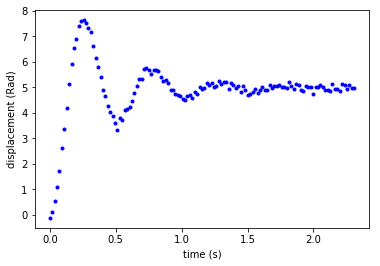

In [2]:
# Load data
with open('../../data/MSDResponse/MSDResponse_noise_small.csv', 'r') as f:
    T = []
    X = []
    N = 0
    row = f.readline().split(',')
    
    while len(row) == 2:
        T.append(float(row[0]))
        X.append(float(row[1]))
        N += 1
        
        row = f.readline().split(',')
        
    T = np.array(T)
    X = np.array(X)
    
plt.figure()
plt.plot(T, X, 'b.')
plt.xlabel('time (s)')
plt.ylabel('displacement (Rad)')

Now we define the curve to fit, the cost function, and the gradients:

In [3]:
# Define function to fit
def x(t, p):
    K = p[0]
    tau = p[1]
    w_d = p[2]
    
    return K*(1 - np.exp(-t/tau)*np.cos(t*w_d))

# Define cost
def c(T, X, p):
    c = 0
    for i in range(T.shape[0]):
        c += (X[i] - x(T[i], p))**2
    return c

# Define Gradients
def x_grad(t, p):
    K = p[0]
    tau = p[1]
    w_d = p[2]
    
    x_K =  (1 - np.exp(-t/tau)*np.cos(t*w_d))
    x_tau = -K*t/(tau**2)*np.exp(-t/tau)*np.cos(t*w_d)
    x_w_d = K*w_d*np.exp(-t/tau)*np.sin(t*w_d)
    
    return np.array([x_K, x_tau, x_w_d])

def c_grad(T, X, p):
    grad_c = np.zeros(3)
    for i in range(T.shape[0]):
        grad_c += -2*x_grad(T[i], p)*(X[i] - x(T[i], p))
    return grad_c

Now we just need to define a starting parameter estimate, specify the number of epochs to run on the data, the batch size to use, and a learning rate.  We also need to make our inital guess at the parameters.  We can inspect the data and see that the DC Gain is going to be on the order of 1 (it will probably be about 5), the time constant will be on the order of 0.1, and the frequency will be on the order of 10.  We will use these values as out initial guesses for the parameters.

In [4]:
# Training Parameters
epochs = 20
batch_size = 10
lr = 0.001
p_0 = [1, 0.1, 10]

# Training
costs = np.zeros(epochs)
p = np.zeros((epochs+1, len(p_0)))
p[0, :] = p_0

n_batches = int(np.ceil(N/batch_size))

for epoch in tnrange(epochs):
    perm = np.random.permutation(N)
    
    for batch in tnrange(n_batches):
        T_batch = T[perm[batch*batch_size:min((batch+1)*batch_size, N)]]
        X_batch = X[perm[batch*batch_size:min((batch+1)*batch_size, N)]]
        costs[epoch] += c(T_batch, X_batch, p[epoch, :])
        grad = c_grad(T_batch, X_batch, p[epoch, :])
        p[epoch, :] -= lr*grad
    
    p[epoch+1, :] = p[epoch, :]
    
p[1:, :] = p[0:-1, :]
p[0, :] = p_0

Now that the training is complete, lets examine the results.  We will plot the final result with the data, we will also plot the histories of cost and the parameter estimates.

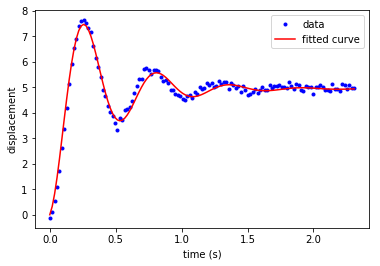

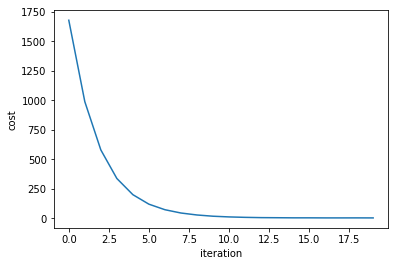

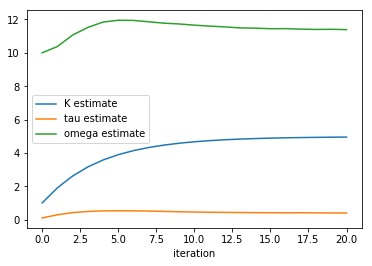

In [5]:
plt.figure()
plt.plot(T, X, 'b.')
plt.plot(T, x(T, p[-1, :]), 'r')
plt.xlabel('time (s)')
plt.ylabel('displacement')
plt.legend(('data', 'fitted curve'))

plt.figure()
plt.plot(costs)
plt.xlabel('iteration')
plt.ylabel('cost')

plt.figure()
plt.plot(p[:, 0])
plt.plot(p[:, 1])
plt.plot(p[:, 2])
plt.xlabel('iteration')
plt.legend(('K estimate', 'tau estimate', 'omega estimate'))

We can see that our system approximated the data relatively well.  We can also see that the learning has reached a steady state as the cost has leveled off, and the parameter estimates have stopped changing.  This is because the gradient has gone zero, indicating that we are at the minimum.

### Pitfalls
While usefull, there are several pitfalls to be aware of when using gradient descent.  Consider a system with a single parameter who's cost surface is given in this figure: ![local_extrema](figs/local_extrema.png) The red dots are places where the gradient of this surface is zero, also known as the functions extrema.  Note the one in the middle is not a minimum, but a maximum point.  If the initial guess at the parameter were set to this value, then the gradient descent algorightm would not work because the gradient is zero at that point.  Fortunately, for this to be an issue, the initial guess must be exactly on the maximum.  If the estimate is even slightly off of that point, then the gradient descent algorightm will move away from it.

More concerning for us is the fact that this function aslo has two minima points.  These are referred to as "Local Minima," or points that hold the smallest value for a range that is a subset of the entire range of the function.  Depending on where we choose our initial guess, we will arrive at one of these minima.  If we choose to start at -0.1, the gradient descent will take us down the gradient toward the minimum on the left, while if we start at 0.1, the gradient will descent toward the minimum on the right.  Once we arrive at a minimum, we only know that it is a local minimum, we need other tools and knowledge to determine if it is the "Global Minimum" or the the smallest value for the entire range of the function.  To counter this, many machine learning algorithms use a technique called Exploration.  Exploration just means sometimes sampeling other random parts of the space just to see well it works and to make sure it is not better than our current solution.  For example, a genetic algorithm would pick several starting points and evaluate the cost at each of these.  It would then eliminate a fraction of the sample points and resample these points randomely near the points it kept.  This process starts by examing a wide area, but will converge to local minima.  The values of these minima can then be evaluated to see which is the Global Minimum.  With Neural Networks, which we will be exploreing in the next tutorial, most local minima are also the Global Minimum, and the larger the network, the less likely a local minimum is to be a sub-optimal minimum.  See [this paper](https://arxiv.org/abs/1412.0233) for details.

### On Your Own
Now lets play with the example a bit.  It is recommended to make a copy of the `OptimizationBySGD.py` file which contains all the code used here and modify it.

1. Adjust the initial guess and training parameters, how do the effect the fit?
    2. What parameter is the algorithm most robust to?
    3. Which is it least robuts to?
    4. What happens when the learning rate gets large?
    5. What about when it gets small?
    6. How does the batch size influence the learning?
    7. What about he number of epochs being trained on?
2. Impliment a more intelligent stop condition and just training for a number of epochs.
    